<a href="https://colab.research.google.com/github/uscmlsystems/ml-systems-hw3-ngcxy/blob/main/Dataflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EE 599 HW 3 Part 2: Dataflow

Your task in this Colab notebook is to fill out the sections that are specified by **TODO** (please search the keyword `TODO` to make sure you do not miss any).

## Dataflow Simulation
This section provides the Processing Element (PE) functions for three dataflow approaches: Weight Stationary, Output Stationary, and Input Stationary. We simulate PEs using the `Process` class from the `multiprocessing` library. Dataflows are managed via `Queue`, and outputs are stored in `Array`.

Your task involves accurately routing weights, activations, and partial sums. We've configured the number of PEs to suit each stationary scenario, avoiding the need for tiling.

**Note**: Multi-processing may lead to deadlocks or starvation. Debug your code thoroughly to prevent endless execution loops.



## Global Variable Settings

We first initialize multiprocessing tools, sets up debug flags, generates random activations and weights, and prints these values.

In [20]:
from multiprocessing import Process, Queue, Array
import random

# Debug Flag
Debug = False

# Number of activations
num_activations = 8
num_weights = 3

# Lets create activations randomly.
activations = [random.uniform(0, 1) for _ in range(num_activations)]
# activations = [1,2,3,4,5]

# The fixed weights. Each PE will be hardcoded to work with a single entry in this list.
weights = [random.uniform(0, 1) for _ in range(num_weights)]
# weights = [1,2,3]
print(activations)
print(weights)

[0.9257522220023774, 0.05620730333820623, 0.661377540060024, 0.3589086580022892, 0.8470595818590742, 0.12852725737127257, 0.13725460435756565, 0.6767531957755301]
[0.07561289111603764, 0.6118159751835558, 0.48859423987436734]


## Convolution Results

We provide 1-D convolution results for validation. Your outputs must exactly match these values.

In [21]:
ground_truth = [0 for _ in range(num_activations-num_weights+1)]
for i in range(num_activations-num_weights+1):
  for k in range(num_weights):
      ground_truth[i] += weights[k]*activations[i+k]
print(ground_truth)

[0.4275325845226046, 0.5842520442845205, 0.6834631510473771, 0.6081803830102689, 0.20974546232352137, 0.42435059040300815]


## Validation Function
The `mse_error` function computes the Mean Square Error (MSE) between two sequences: the `ground_truth` (expected results) and `output` (simulated results). By iterating through each pair of corresponding values in these sequences, the function calculates the square of their difference, summing these squared errors to derive the total MSE. It then prints both the expected and simulated results, followed by the MSE, rounded to four decimal places. If your simulated results are closed to the ground truth, the MSE will be closed to 0.

In [22]:
def mse_error(ground_truth, output):
    error = 0.0
    for gt, out in zip(ground_truth, output):
        error += (gt-out) ** 2
    print(f"The expected results : {ground_truth}")
    print(f"The simulated results: {output[:]}")
    print(f"The Mean Square Error: {error:.4f}")

## Weight Stationary Configuration

The graph below shows the Weight Stationary Configuration for a data processing architecture, with the following modification: the Partial Sum (`Psum`) input for the first PE is directed from the Producer (not the Global Buffer), and the final PE's output is connected to the Consumer (not the Global Buffer).

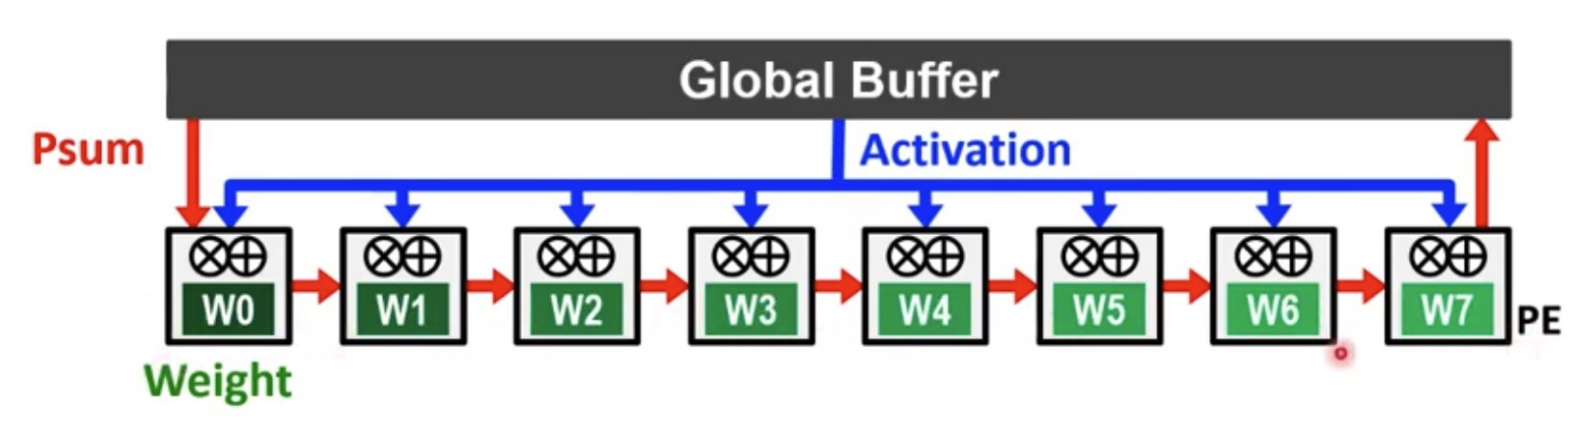

## Producer

The Producer has a simple functionality: it sends partial sum values of 0 to the first PE.


In [23]:
def producer(left_partial_sum_queue):
    dummy = 0
    counter = 0
    while counter < num_activations - num_weights + 1:
        left_partial_sum_queue.put(dummy)
        counter+=1
    print(f"producer is Done!")

## Consumer

The Comsumer has a simple functionality: it receives partial sum values from the **last** PE. It utilizes `output_array`, a shared variable, to store the results of the convolution operations.

In [24]:
def consumer(right_partial_sum_queue, output_array):
    counter = 0
    print(f"consumer dummy: {counter}")
    while counter < num_activations - num_weights + 1:
        right_partial_sum = right_partial_sum_queue.get()
        output_array[counter] = right_partial_sum
        counter += 1
        print(f'comsumer {counter}: {right_partial_sum}')
    print(f"consumer is Done!")

## WS_worker

Each PE is designed to receive an input activation and a partial sum via the `left_partial_sum_queue`. Upon receipt, it processes these inputs to update the partial sum, subsequently forwarding this updated value to the `right_partial_sum_queue`.

Hint: Consider the calculation of the first two partial sums as a guide. The first partial sum is obtained by the expression `w[0]*act[0] + w[1]*act[1] + w[2]*act[2]`. The second follows as `w[0]*act[1] + w[1]*act[2] + w[2]*act[3]`. Note that the accumulation involves only a subset of the activations.

### **TODO 1**:

Finish the implementation of `WS_worker` function. Determine the appropriate range of indices for the activations to be processed in parallel.

In [25]:
def WS_worker(id, weight, input_queue, left_partial_sum_queue, right_partial_sum_queue):
    '''
    Arg(s):
      id                       (int): index of the PE
      weight                 (float): stored weight in RegFile of the PE
      input_queue            (Queue): boardcasted inputs
      left_partial_sum_queue (Queue): partial sum passed from the prrevious PE
      right_partial_sum_queue(Queue): partial sum passing to the next PE
    '''

    while True:
        # Get an activation value from the input queue
        data = input_queue.get()
        # print(f'***worker {id} receives data {data}***')
        # Check if the activation is a termination signal (None), indicating the end of processing
        if data is None:
            break

        activation, time_step = data
        # print(f'***worker {id} receives activation {activation} time_step {time_step}***')
        # TODO: Each PE only takes the data within certain time step
        if time_step < id or time_step > id+num_activations-num_weights:
          # print(f'***worker {id} step {time_step} is out***')
          continue

        # Get the left partial sum from the left_partial_sum_queue
        left_partial_sum = left_partial_sum_queue.get()
        # print(f'***worker {id} gets left {left_partial_sum}***')

        # Print received information for debugging or logging purposes
        if Debug:
          print(f"Worker ID {id}: Received Activation: {activation}, Left Partial Sum: {left_partial_sum}")

        # Calculate the right partial sum using the received activation and weight
        right_partial_sum = left_partial_sum + activation * weight

        # Put the calculated right partial sum into the right_partial_sum_queue
        right_partial_sum_queue.put(right_partial_sum)
        # print(f'***worker {id} puts right {right_partial_sum}***')

    # Print a message indicating that this worker has completed its task
    print(f"Worker ID {id}: is Done!")

## Putting Everything Together

In the following cell, we connect all PEs together with the Producer and Consumer.

In [26]:
# The number of PEs in the system
num_pes = num_weights

# Create input queues for activations
input_queues = [Queue() for _ in range(num_pes)]

# Create the partial sum queue that is used by PEs to communicate partial sum.
partial_sum_queues = [Queue() for _ in range(num_pes+1)]

# Create a global variable for the outputs
# The consumer function can store the partial sums into the shared memory for further validation
WS_output = Array('d', [0.0 for _ in range(num_activations-num_weights+1)])

# List of processes: [Producer, PE[0]...PE[num_pes-1], Consumer]
processes = []

# Create and start the producer process.
p = Process(target=producer, args=(partial_sum_queues[0],))
processes.append(p)
p.start()

# Create and start a process for each PE.
# Note that the partial sum output of one is connected to the partial sum input
# of the next one.
for i in range(num_pes):
    initial_left_partial_sum = 0 if i == 0 else None
    p = Process(target=WS_worker, args=(
        i, weights[i], input_queues[i], partial_sum_queues[i], partial_sum_queues[i+1]))
    processes.append(p)
    p.start()

# Create and start the consumer process.
p = Process(target=consumer, args=(partial_sum_queues[num_pes], WS_output))
processes.append(p)
p.start()

# Broadcasting the activation to all PEs.
for i, activation in enumerate(activations):
    print(f"Writing: i:{i},  activation: {activation}")
    for q in input_queues:
        q.put((activation, i))

print("Done broadasting Activations!")

# Signal all PEs to stop processing once all activations have been sent
for q in input_queues:
    q.put(None)
print("Done broadcasting None!")

# Make sure to join the PE processes to clean up properly
for i, p in enumerate(processes):
    p.join()

print("All Done!")
mse_error(ground_truth, WS_output)

producer is Done!
consumer dummy: 0
comsumer 1: 0.4275325845226046Worker ID 1: is Done!Worker ID 0: is Done!Worker ID 2: is Done!



comsumer 2: 0.5842520442845205
comsumer 3: 0.6834631510473771
comsumer 4: 0.6081803830102689
comsumer 5: 0.20974546232352137
comsumer 6: 0.42435059040300815
consumer is Done!
Writing: i:0,  activation: 0.9257522220023774
Writing: i:1,  activation: 0.05620730333820623
Writing: i:2,  activation: 0.661377540060024
Writing: i:3,  activation: 0.3589086580022892
Writing: i:4,  activation: 0.8470595818590742
Writing: i:5,  activation: 0.12852725737127257
Writing: i:6,  activation: 0.13725460435756565
Writing: i:7,  activation: 0.6767531957755301
Done broadasting Activations!
Done broadcasting None!
All Done!
The expected results : [0.4275325845226046, 0.5842520442845205, 0.6834631510473771, 0.6081803830102689, 0.20974546232352137, 0.42435059040300815]
The simulated results: [0.4275325845226046, 0.5842520442845205, 0.6834631510473771, 0.6081803830102689, 0.209745

## Output Stationary Configuration
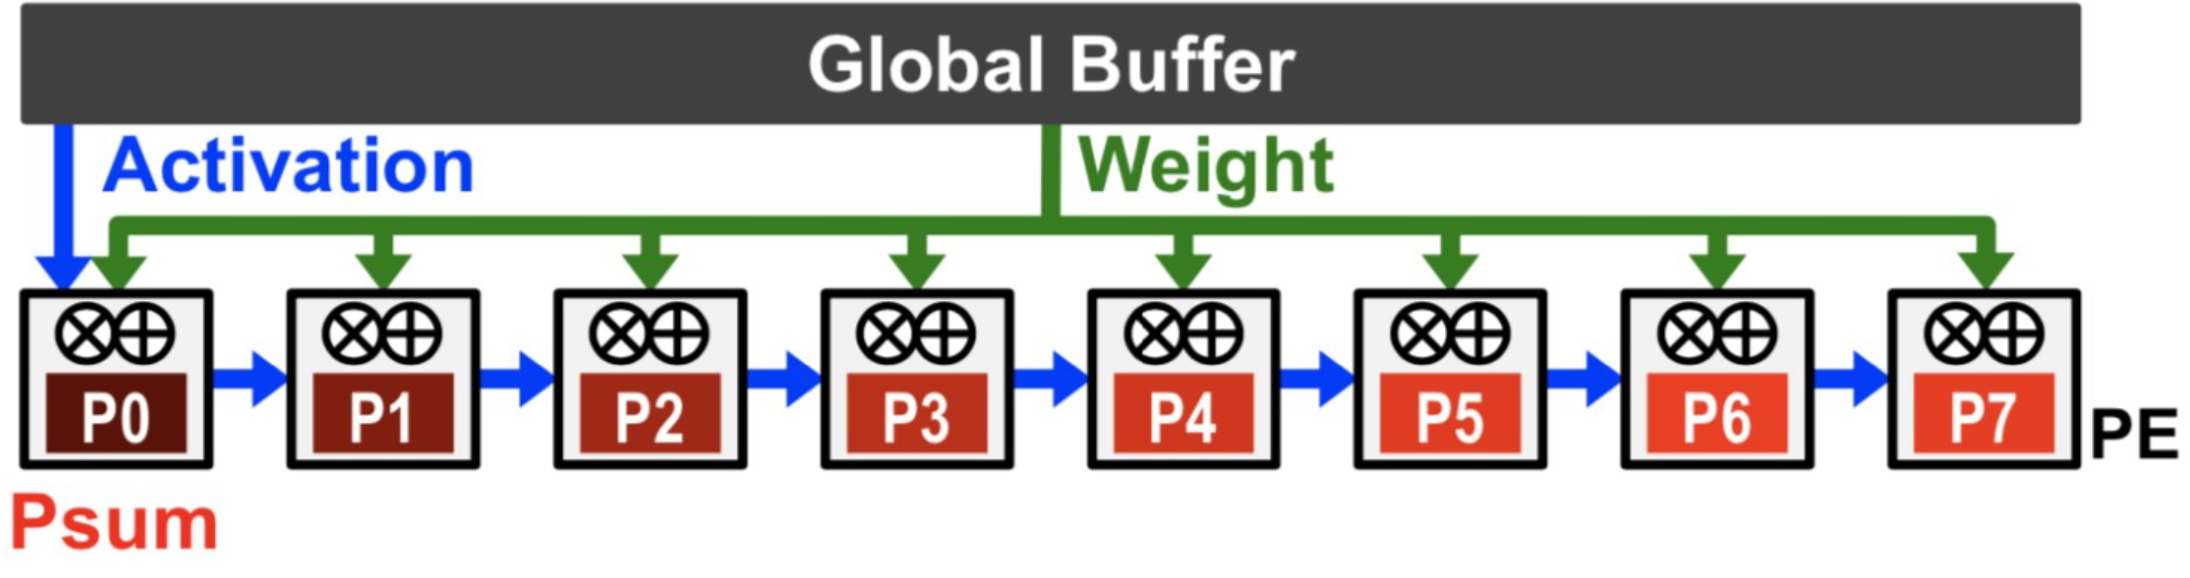

## OS_workers

In the Output Stationary configuration, each PE retains the output feature map for the duration of its computation. Here's a breakdown of the PE's functionality in this setup:

* Data Handling: Each PE receives input data and associated weight data. It processes this data and then forwards the input data to the queue of the next PE in the sequence.
* Register File Update: Within each PE, a register file is updated using the formula `RegFile += activation * weight`.
* Partial Sum Calculation: Use a subset of the input data for multiplication and addition to generate partial sums.
    
Hint: Consider the calculation of the first two partial sums as a guide. The first partial sum is obtained by the expression `w[0]*act[0] + w[1]*act[1] + w[2]*act[2]`. The second follows as `w[0]*act[1] + w[1]*act[2] + w[2]*act[3]`. Note that weights are retained in the weight_queue until the PE receives the valid input data.

### **TODO 2**:
Finish the implementation of `OS_worker` function.

* Employ the `get()` and `put()` functions to accurately manage data transfer between PEs and handle the storage and retrieval of weights in the weight_queue.
* Select the appropriate index range for the input data to ensure accurate multiplication and addition operations, aligning with the calculation of partial sums.

In [27]:
def OS_worker(id, partial_output_register, activate_queue, weight_queue, output_queue):
    ## The PE function for the Output Stationary Scheme
    # OS_worker takes the input queue for activate_queue and weight_queue
    # The data in the activate_queue will pass to the output_queue
    # The partial_output_register is the RegFile in the PE

    while True:
        # Get an activation value from the input queue
        data = activate_queue.get()
        # print(f'***worker {id} receives data {data}***')
        # Check if the activation is a termination signal (None), indicating the end of processing
        if data is None:
            # print(f'***worker {id} receives None***')
            output_queue.put(data)
            break

        activation, time_step = data
        # TODO: Each PE takes input within certain time step
        if time_step<id or time_step>id+num_weights-1:
            output_queue.put(data)
            # print(f'***worker {id} skips step {time_step}***')
            continue

        # print(f'***worker {id} continues {activation} {time_step} ***')

        # Get kernel weights from the weight Queue
        weight = weight_queue.get()
        # print(f'***worker {id} proceeds weight {weight}***')

        # Update the RegFile in the PE
        partial_output_register[id] += weight*activation
        # print(f'***worker {id}: add {weight} * {activation} output {partial_output_register[id]}***')

        # Print received information for debugging or logging purposes
        if Debug:
          print(f"Worker ID {id}: Received Activation (Time Step {time_step:0>2d}: {activation:.4f})")
          print(f"Register [{id}]: {partial_output_register[id]:.4f}")

        # Pass the input data into the output_queue
        # print(f'***worker {id} put data {data}***')
        output_queue.put(data)

    # Print a message indicating that this worker has completed its task
    print(f"Worker ID {id}: is Done!")

### **TODO 3**:

In the following cell, integrate the Producer, PEs, and Consumer into a unified processing pipeline:

* Broadcast Weights: Send the same weights to all PEs using Queue to ensure uniform processing capabilities across the network.
* Forward Activations: Sequentially move activation data from one PE to the next via Queue, adhering to the sequence outlined in the configuration diagram.

In [28]:
# The number of PEs in the system
num_pes = num_activations - num_weights + 1

# Create input queues for activations
activate_queues = [Queue() for _ in range(num_pes+1)]

# Create the weight_queue for boardcasting the weights
weight_queues = [Queue() for _ in range(num_pes)]

# List of processes: [PE[0]...PE[num_pes-1]]
processes = []

# Create a global variable for the PE RegFiles
# The RegFile is the outcome of the convolution
# RegFiles Arrray is a convenient way to access the outputs
PE_RegFiles = Array('d', [0.0 for _ in range(num_pes)])

# Create and start a process for each PE.
for i in range(num_pes):
    p = Process(target=OS_worker, args=(
        i, PE_RegFiles, activate_queues[i], weight_queues[i], activate_queues[i+1]))
    processes.append(p)
    p.start()

# TODO: Broadcasting the weights to all PEs.
# The weights will be stored in the queues until the PE fetching valid activations
for i in range(num_weights):
    for w in weight_queues:
        w.put(weights[i])

print("Done broadasting Weights!")

# TODO: Pass the activation data input the leftmost PE
for i, activation in enumerate(activations):
    activate_queues[0].put((activation, i))

# Pass the termination signal in the end of the input sequence
activate_queues[0].put(None)
print("Done broadcasting None!")

# Make sure to join the PE processes to clean up properly
for i, p in enumerate(processes):
    p.join()

OS_output = PE_RegFiles

print("All Done!")
mse_error(ground_truth, OS_output)

Worker ID 0: is Done!
Worker ID 1: is Done!Worker ID 4: is Done!Worker ID 2: is Done!Worker ID 3: is Done!



Worker ID 5: is Done!
Done broadasting Weights!
Done broadcasting None!
All Done!
The expected results : [0.4275325845226046, 0.5842520442845205, 0.6834631510473771, 0.6081803830102689, 0.20974546232352137, 0.42435059040300815]
The simulated results: [0.4275325845226046, 0.5842520442845205, 0.6834631510473771, 0.6081803830102689, 0.20974546232352137, 0.42435059040300815]
The Mean Square Error: 0.0000


## Input Stationary Configuration   

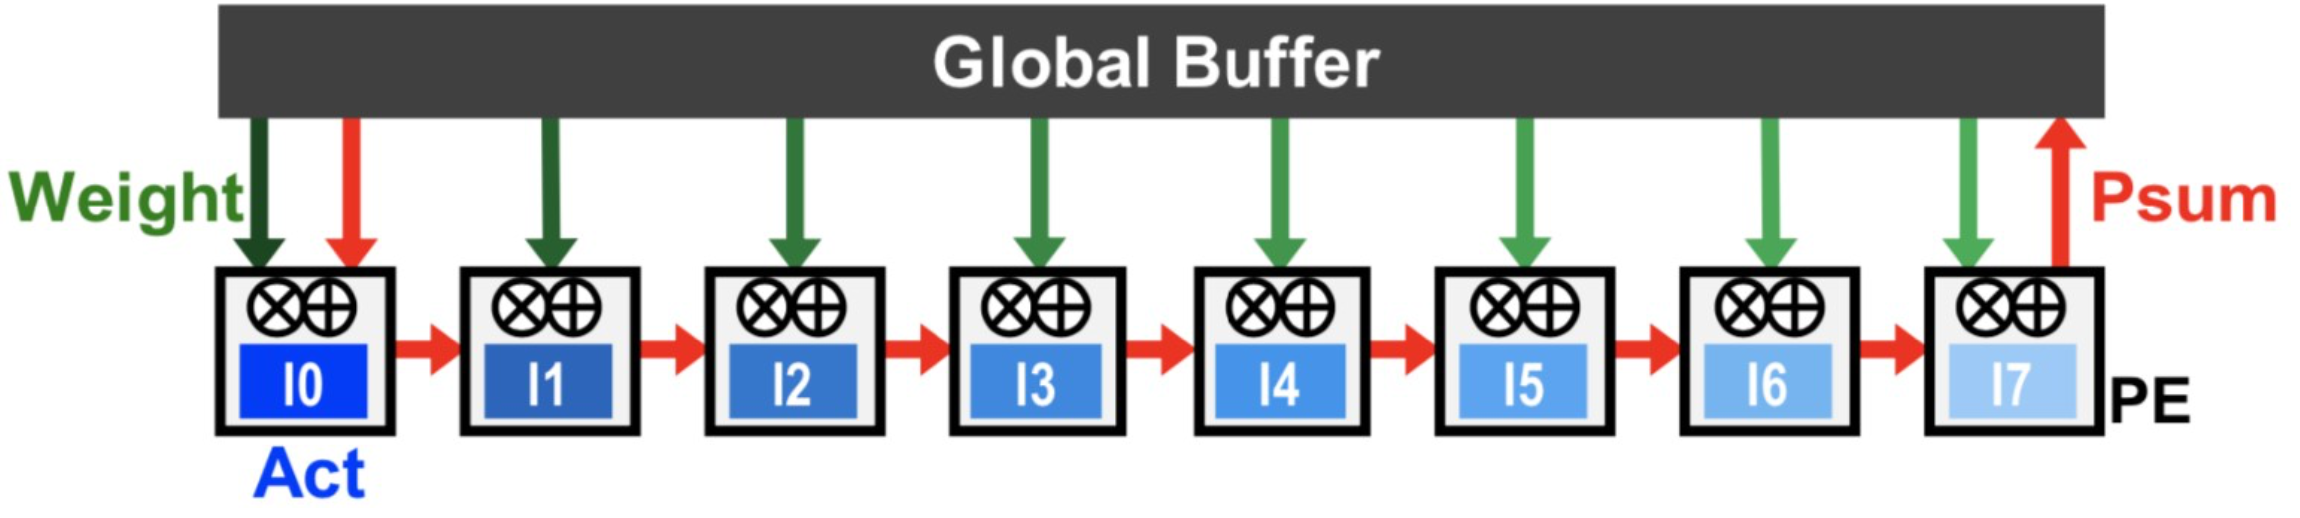

## IS_worker

In the Input Stationary Configuration, each PE operates by receiving an input weight and a partial sum from the `left_partial_sum_queue`. After receiving these inputs, the PE proceeds to update the partial sum. Once the partial sum is updated, it is then passed forward to the `right_partial_sum_queue` for subsequent processing.

In [29]:
def IS_worker(id, activation, input_queue, left_partial_sum_queue, right_partial_sum_queue):
    '''
    Arg(s):
      id                       (int): index of the PE
      activation             (float): stored activation in RegFile of the PE
      input_queue            (Queue): unicasted inputs
      left_partial_sum_queue (Queue): partial sum passed from the prrevious PE
      right_partial_sum_queue(Queue): partial sum passing to the next PE
    '''

    while True:
        # Get an weights value from the input queue
        weight = input_queue.get()
        # Check if the activation is a termination signal (None), indicating the end of processing
        if weight is None:
            right_partial_sum_queue.put(0)
            break

        # Get the left partial sum from the left_partial_sum_queue
        left_partial_sum = left_partial_sum_queue.get()

        # Print received information for debugging or logging purposes
        if Debug:
          print(f"Worker ID {id}: Received Weight: {weight}, Left Partial Sum: {left_partial_sum}")

        # Calculate the right partial sum using the received activation and weight
        right_partial_sum = left_partial_sum + activation * weight

        # Put the calculated right partial sum into the right_partial_sum_queue
        right_partial_sum_queue.put(right_partial_sum)

    # Print a message indicating that this worker has completed its task
    print(f"Worker ID {id}: is Done!")

### **TODO 4**:

In the following cell, integrate the Producer, PEs, and Consumer into a unified processing pipeline:

* Unicast Weights: Distribute the weights to each PE individually, ensuring that each PE receives the correct weight data it needs for its part of the computation.

* Pass Partial Sums: Pass the partial sums from one PE to the next.

In [30]:
# The number of PEs in the system
num_pes = num_activations

# Create input queues for activations
input_queues = [Queue() for _ in range(num_pes)]

# Create a global variable for the outputs
# The consumer function can store the partial sums into the shared memory for further validation
IS_output = Array('d', [0.0 for _ in range(num_activations-num_weights+1)])

# Create the partial sum queue that is used by PEs to communicate partial sum.
partial_sum_queues = [Queue() for _ in range(num_pes+1)]

# List of processes: [Producer, PE[0]...PE[num_pes-1], Consumer]
processes = []

# Create and start the producer process.
p = Process(target=producer, args=(partial_sum_queues[0], ))
processes.append(p)
p.start()

# Create and start a process for each PE.
# Note that the partial sum output of one is connected to the partial sum input
# of the next one.
for i in range(num_pes):
    p = Process(target=IS_worker, args=(
        i, activations[i], input_queues[i], partial_sum_queues[i], partial_sum_queues[i+1]))
    processes.append(p)
    p.start()

# Create and start the consumer process.
p = Process(target=consumer, args=(
    partial_sum_queues[num_pes], IS_output))
processes.append(p)
p.start()


# TODO: Unicasting weights to all PEs.
for i in range(num_activations-num_weights+1):
    for j in range(num_weights):
        input_queues[i+j].put(weights[j])
    for j in range(i+num_weights, num_pes):
        input_queues[j].put(0)



print("Done unicasting Weights!")

# Signal all PEs to stop processing once all activations have been sent
for q in input_queues:
    q.put(None)
print("Done broadcasting None!")

# Make sure to join the PE processes to clean up properly
for i, p in enumerate(processes):
    p.join()

print("All Done!")
mse_error(ground_truth, IS_output)

producer is Done!
consumer dummy: 0
comsumer 1: 0.4275325845226046Worker ID 1: is Done!
Worker ID 0: is Done!Worker ID 3: is Done!Worker ID 2: is Done!

Worker ID 4: is Done!
Worker ID 7: is Done!
comsumer 2: 0.5842520442845205Worker ID 6: is Done!Worker ID 5: is Done!




comsumer 3: 0.6834631510473771
comsumer 4: 0.6081803830102689
comsumer 5: 0.20974546232352137
comsumer 6: 0.42435059040300815
consumer is Done!
Done unicasting Weights!
Done broadcasting None!
All Done!
The expected results : [0.4275325845226046, 0.5842520442845205, 0.6834631510473771, 0.6081803830102689, 0.20974546232352137, 0.42435059040300815]
The simulated results: [0.4275325845226046, 0.5842520442845205, 0.6834631510473771, 0.6081803830102689, 0.20974546232352137, 0.42435059040300815]
The Mean Square Error: 0.0000
